In [53]:
from itertools import product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from itertools import combinations
from download_data import download_price_data
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

# Data

In [13]:
#### get MPD data ####
data = pd.read_csv("../data/mpd_stats.csv")
ticker_def = pd.read_csv("../data/ticker_def.csv", index_col=["ticker"])

data = data.merge(ticker_def, left_on=["market"], right_index=True, how="left")
data["idt"] = pd.to_datetime(data["idt"])
# data.set_index(["market", "idt"], inplace=True

equity = data.loc[data["type"].isin(["equity", "equity_idx"])]
tickers = equity["market"].unique()


#### get close price ####
price_df_list = []
start_date, end_date = equity["idt"].min(), equity["idt"].max()
for t in [["BAC", "C"], ["IYR", "SPY"]]:
    price_df = download_price_data(tickers=t,     
                                   start_date=start_date, end_date=end_date)
    price_df_list.append(price_df)
    
price_df = pd.concat(price_df_list, axis=1)
close = price_df["adj_close"]

log_ret = pd.DataFrame(index=close.index)
for t, m, prob_name in [("BAC", 3, "bac"), 
                        ("C", 3, "citi"), 
                        ("IYR", 3, "iyr"), 
                        ("SPY", 6, "sp6m"), 
                        ("SPY", 12, "sp12m")]:
    close_shift = close.copy()
    close_shift.index = close_shift.index - pd.DateOffset(months=m)
    close_shift = close_shift.reset_index().drop_duplicates(subset="date", keep='last').set_index("date")
    idx = close_shift.index.intersection(close.index)
    log_ret.loc[:, prob_name] = np.log(close_shift.loc[idx, t].ffill() / close.loc[idx, t])
    
close = close.reset_index().melt(id_vars=['date'], var_name='ticker', value_name='price')
for t, m, prob_name in [("BAC", 3, "bac"), 
                        ("C", 3, "citi"), 
                        ("IYR", 3, "iyr"), 
                        ("SPY", 6, "sp6m")]:
    close.loc[close[close['ticker']==t].index,'ticker'] = prob_name

# Strategy

**select indicators as factors(find 5 indicators with the least correlations for each ticker)**

For the trade on SPY, here I use only the data of sp6m

For each day, do a rolling regression. Regress the return of the ticker on the value of the 5 factors. And use the predicted value to be the next day's investment.

After we make the regressions on all the tickers. We got the investment on each ticker every day. Then rescale it to make the absolute value add up to 1. The rescaled value will be the weight(or position) on that ticker on that day.

In [14]:
equity = equity.rename(columns={'idt':'date','market':'ticker'})
equity = equity[equity['ticker']!='sp12m']

all_data = pd.merge(close,equity,on=['ticker','date'],how='left')
all_data = all_data.fillna(method='ffill')
all_data = all_data.drop(['name','type'],axis=1)
all_data = all_data.sort_values(by=['ticker','date'])

all_data['ret'] = all_data.groupby('ticker')['price'].pct_change()
all_data = all_data.dropna()
tickers = tickers[tickers != 'sp12m']

In [15]:
def find_least_correlated_vars(corr_matrix, num_vars=5):
    corr_tuples = [(i, j, corr_matrix.loc[i, j])
                   for i in corr_matrix.columns 
                   for j in corr_matrix.columns 
                   if i < j]

    sorted_corr = sorted(corr_tuples, key=lambda x: abs(x[2]))

    vars_combinations = combinations(corr_matrix.columns, num_vars)

    min_corr_value = float('inf')
    best_combination = None

    for combo in vars_combinations:
        pairs = combinations(combo, 2)
        avg_corr = np.mean([abs(corr_matrix.at[pair[0], pair[1]]) for pair in pairs])
        if avg_corr < min_corr_value:
            min_corr_value = avg_corr
            best_combination = combo

    return best_combination


factors = {}
indicators = equity.drop(['ticker','date','name','type',
                          'maturity_target','lg_change_decr','lg_change_incr'],axis=1).columns.to_list()
for ticker in tickers:
    corr_matrix = all_data[all_data['ticker']==ticker]
    corr_matrix = corr_matrix[indicators].corr()
    factors[ticker] = find_least_correlated_vars(corr_matrix)
factors

{'bac': ('mu', 'skew', 'kurt', 'p50', 'p90'),
 'citi': ('mu', 'skew', 'kurt', 'p50', 'prInc'),
 'iyr': ('mu', 'sd', 'skew', 'kurt', 'prInc'),
 'sp6m': ('mu', 'sd', 'skew', 'kurt', 'p50')}

In [16]:
### construct some new factors ###

# all_data['sr'] = all_data.groupby('ticker')['ret'].apply(lambda x:x.rolling(90).mean()/x.rolling(90).std()).to_list()
# for ticker in factors:
#     factors[ticker] = factors[ticker] + ('sr',)

**factor trading strategy**

In [34]:
def get_predicted_ret(df,factor,window_size=100,method='OLS'):
    if method == 'OLS':
        df = get_OLS(df,factor,window_size)
    elif method == 'RF':
        df = get_RF(df,factor,window_size)
    elif method == 'GBM':
        df = get_GBM(df,factor,window_size)
    
    return df

In [35]:
def get_RF(df,factor,window_size):
    
    def rolling_regression(X, y):
        model = RandomForestRegressor(n_estimators=30, max_depth=10)
        model.fit(X[:-1], y[:-1])
        prediction = model.predict(X[-1:])
        return prediction[0]

    predicted_returns = pd.Series(index=df.index)

    for start in range(len(df) - window_size):
        end = start + window_size
        window_df = df.iloc[start:end]
        X = window_df[factor]
        y = window_df['ret']
        predicted_returns.iloc[end] = rolling_regression(X, y)

    df['predicted_return'] = predicted_returns
    
    return df

In [36]:
def get_OLS(df,factor,window_size):
    
    def rolling_regression(X, y):
        model = LinearRegression().fit(X, y)
        return model.predict(X.iloc[-1].values.reshape(1, -1))[0]

    predicted_returns = pd.Series(index=df.index)

    for start in range(len(df) - window_size):
        end = start + window_size
        window_df = df.iloc[start:end]
        X = window_df[factor]
        y = window_df['ret']
        predicted_returns.iloc[end] = rolling_regression(X, y)

    df['predicted_return'] = predicted_returns
    
    return df

In [37]:
def get_GBM(df,factor,window_size):
    
    def rolling_regression(X, y):
        model = GradientBoostingRegressor(n_estimators=30, max_depth=10)
        model.fit(X[:-1], y[:-1])
        prediction = model.predict(X[-1:])
        return prediction[0]

    predicted_returns = pd.Series(index=df.index)

    for start in range(len(df) - window_size):
        end = start + window_size
        window_df = df.iloc[start:end]
        X = window_df[factor]
        y = window_df['ret']
        predicted_returns.iloc[end] = rolling_regression(X, y)

    df['predicted_return'] = predicted_returns
    
    return df

In [38]:
def strategy_result(method,all_data):
    print(method)
    strategy = []
    all_data = all_data.fillna(0)
    for ticker in tickers:
        print(ticker)
        df = all_data[all_data['ticker']==ticker]
        factor = list(factors[ticker])

        df = df.set_index('date',drop=True)

        df = get_predicted_ret(df,factor,method=method).reset_index()
        strategy.append(df)
    strategy = pd.concat(strategy)
    ret_df = strategy.pivot(index = 'date',columns='ticker',values = 'ret').dropna()
    position = strategy.pivot(index = 'date',columns='ticker',values = 'predicted_return').dropna()
    position['total'] = np.abs(position).sum(axis=1)
    position.loc[:,tickers] = position.loc[:,tickers].div(position['total'], axis=0)

    cost = 0.0001
    delta_pos = position.diff().fillna(0)

    result = (ret_df*position - cost*delta_pos).drop(['total'],axis=1)
    result['ret'] = result[tickers].sum(axis=1)
    result['pnl'] = np.cumprod(1+result['ret'])-1
    result = result.dropna()
    
    return result

In [42]:
all_result = []
for method in ['OLS','RF','GBM']:
    result = strategy_result(method,all_data)
    all_result.append(result[['pnl']].rename(columns={'pnl':method}))
all_pnl = pd.concat(all_result)

OLS
bac
citi
iyr
sp6m
RF
bac
citi
iyr
sp6m
GBM
bac
citi
iyr
sp6m


In [45]:
all_pnl = pd.concat(all_result,axis=1)

In [63]:
all_ret = all_pnl.apply(lambda x:np.log((x+1)/(x+1).shift(1)))

ticker,OLS,RF,GBM
date,,,
2010-06-10,NaN,NaN,NaN
2010-06-11,-0.000836,-0.004869,-0.003975
2010-06-14,0.003440,0.005570,0.007050
2010-06-15,-0.014598,-0.014916,-0.019280
2010-06-16,-0.000399,0.000232,-0.001947
...,...,...,...
2024-01-04,-0.001836,-0.000119,0.000513
2024-01-05,-0.001097,0.000487,-0.000616
2024-01-08,-0.002011,-0.010602,-0.011083


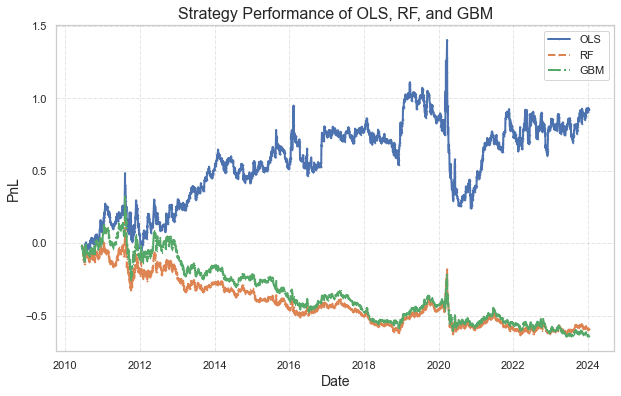

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(all_pnl.index, all_pnl['OLS'], label='OLS', marker='o', linestyle='-', linewidth=2, markersize=0.5)
plt.plot(all_pnl.index, all_pnl['RF'], label='RF', marker='s', linestyle='--', linewidth=2, markersize=0.5)
plt.plot(all_pnl.index, all_pnl['GBM'], label='GBM', marker='^', linestyle='-.', linewidth=2, markersize=0.5)

plt.legend()

plt.title('Strategy Performance of OLS, RF, and GBM', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('PnL', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

# Performance

In [65]:
def performance_summary(return_data):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Annualized Return')*252
    summary_stats['Annualized Volatility'] = return_data.std()*np.sqrt(252)
    summary_stats['Annualized Sharpe Ratio'] = summary_stats['Annualized Return']/summary_stats['Annualized Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [68]:
performance_summary(all_ret)

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery
ticker,,,,,,,,,,,,,
OLS,0.049915,0.223631,0.223202,-0.466409,16.051804,-0.019074,-0.034232,-0.148051,0.120060,-0.505849,2020-03-23,2020-11-10,NaT
RF,-0.065436,0.238644,-0.274199,-0.190929,14.550016,-0.021542,-0.036607,-0.145133,0.149277,-0.768108,2011-08-08,2022-12-21,NaT
GBM,-0.074193,0.236954,-0.313112,-0.158223,14.784727,-0.021091,-0.035889,-0.146390,0.149670,-0.809380,2011-08-08,2023-12-29,NaT


In [17]:
performance_summary(result[['ret']].loc['2021':])

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery
ticker,,,,,,,,,,,,,
ret,0.122218,0.180555,0.676901,-0.146186,2.984993,-0.018403,-0.026,-0.060802,0.047035,-0.167034,2021-11-19,2022-11-30,2023-11-03


**Further Modification**

1. Out-of-Sample test

2. use the data of sp12m

3. more factors(need more data)

4. Other methods to generate the predicted return(machine learning)